#Анализ энергоэффективности зданий Нью-Йорка 

1. Скачать данные об энергоэффективности зданий Нью-Йорка https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml (2018 Energy and Water Data Disclosure (Data for Calendar Year 2017, файл spreadsheet)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel('https://www1.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name='Information and Metrics')
df.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area (ft²),Self-Reported Gross Floor Area (ft²),Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Propane Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,DOF Benchmarking Submission Status
0,1,4593574,The Argonaut Building,NaN,NaN,1.010288e+09,1010287502,1024898,224 West 57th St,NaN,10019,Not found,Not found,Manhattan,Not found,169416,Office,"Bank Branch, Office",Office,164754.0,Bank Branch,4662.0,NaN,NaN,1909,1,95,Whole Building,Whole Building,90.0,138.4,141.0,53.8,56.2,11.3,0.1,NaN,NaN,NaN,NaN,NaN,NaN,1133475.1,NaN,NaN,1435754.7,16672.2,6551394.1,1920103.6,1920103.6,NaN,NaT,732.4,76.3,656.1,3635.5,21.46,Not found,2018-02-14,Not found
1,3,2967701,Cathedral Preparatory Seminary,NaN,NaN,4.018720e+09,4-01872-0007,4046340,56-25 92nd Street,NaN,11373,Not found,Not found,Queens,Not found,94380,K-12 School,K-12 School,K-12 School,94380.0,NaN,NaN,NaN,NaN,1963,1,100,Whole Building,NaN,100.0,43.5,46.8,28.4,31.3,2.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2068300.1,23243.7,616343.7,180640.0,184131.9,NaN,NaT,164.5,109.9,54.6,102.9,1.09,Not found,2018-02-14,Not found
2,4,4898531,The Nomad Hotel,NaN,NaN,1.008290e+09,1-00829-0050,1080710,1170 Broadway,NaN,10001-7507,Not found,Not found,Manhattan,Not found,125000,Hotel,Hotel,Hotel,125000.0,NaN,NaN,NaN,NaN,1999,1,85,Whole Building,Whole Building,83.0,271.1,274.7,130.2,133.7,18.8,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8245445.1,86776.9,8033914.4,2354605.3,2354605.3,NaN,NaT,1150.2,438.0,712.3,10762.6,86.10,Not found,2018-02-14,Not found
3,5,2917939,10 West 27 Street Corp,NaN,NaN,1.008280e+09,1-00828-0053,1015657,1155 Broadway,NaN,10001,Not found,Not found,Manhattan,Not found,50000,Hotel,Hotel,Hotel,50000.0,NaN,NaN,NaN,NaN,1994,1,100,Whole Building,NaN,27.0,163.0,167.9,76.5,80.8,11.7,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1848519.4,20520.9,1976691.9,579335.2,582516.1,NaN,NaT,273.4,98.2,175.3,790.1,15.80,Not found,2018-02-14,Not found
4,6,3878205,Westbury Realty,NaN,NaN,1.000650e+09,1-00065-0024,1001105,24 John Street,NaN,10038,Not found,Not found,Manhattan,Not found,50000,Hotel,Hotel,Hotel,50000.0,NaN,NaN,NaN,NaN,2012,1,0,Whole Building,Whole Building,99.0,64.2,64.2,20.5,20.5,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1022951.6,299809.9,299809.9,NaN,NaT,90.7,0.0,90.7,143.0,2.86,Not found,2018-02-14,Not found


2. Провести чистку данных (пропуски данных, неинформативные признаки, аномалии и т.п.)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Order                                                       34355 non-null  int64         
 1   Property Id                                                 34355 non-null  int64         
 2   Property Name                                               34355 non-null  object        
 3   Parent Property Id                                          1723 non-null   object        
 4   Parent Property Name                                        1723 non-null   object        
 5   BBL - 10 digits                                             33625 non-null  float64       
 6   NYC Borough, Block and Lot (BBL) self-reported              33626 non-null  object        
 7   NYC Building Identific

In [ ]:
df['ENERGY STAR Score'].describe()

count    25454.000000
mean        53.927163
std         32.573629
min          1.000000
25%         25.000000
50%         56.000000
75%         83.000000
max        100.000000
Name: ENERGY STAR Score, dtype: float64

In [ ]:
df = df.loc[df['ENERGY STAR Score']>0]

In [ ]:
col_list = []

for col in df:
  if df[col].nunique() < 2 or df[col].nunique() == len(df):
    col_list.append(col)

col_list

['Order',
 'Street Number',
 'Street Name',
 'DOF Gross Floor Area (ft²)',
 'Metered Areas (Energy)',
 'Propane Use (kBtu)',
 'Water Required?',
 'DOF Benchmarking Submission Status']

In [ ]:
df = df.drop(columns = col_list, axis = 1)

In [ ]:
col_list2 = ['Property Id','Property Name','Parent Property Id', 
            'Parent Property Name', 'BBL - 10 digits', 'NYC Borough, Block and Lot (BBL) self-reported',
            'NYC Building Identification Number (BIN)', 'Postal Code', 
            'Generation Date']
df = df.drop(columns = col_list2, axis = 1)

In [ ]:
col_list3 = []

for col in df:
  s = sum(df[col].isna())
  if s/len(df) >= 0.5:
   col_list3.append(col)

col_list3

['Address 2 (self-reported)',
 '2nd Largest Property Use Type',
 '2nd Largest Property Use - Gross Floor Area (ft²)',
 '3rd Largest Property Use Type',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Metered Areas  (Water)',
 'Fuel Oil #1 Use (kBtu)',
 'Fuel Oil #2 Use (kBtu)',
 'Fuel Oil #4 Use (kBtu)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'District Steam Use (kBtu)',
 'District Hot Water Use (kBtu)',
 'District Chilled Water Use (kBtu)',
 'Annual Maximum Demand (kW)',
 'Annual Maximum Demand (MM/YYYY)']

In [ ]:
df = df.drop(columns = col_list3, axis = 1)

In [ ]:
df.shape

(25454, 27)

In [ ]:
# посмотрим на оставшиеся строковые признаки и решим, как их обработать
df.describe(include='object')

,Address 1 (self-reported),Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type
count,25454,25454,25454,25454,25454
unique,17489,12,33,580,20
top,410 West 118th Street,Manhattan,Multifamily Housing,Multifamily Housing,Multifamily Housing
freq,70,9223,18973,16311,18986


In [ ]:
# в переменной адреса очень много уникальных значений, но в основном за счет разницы в написании улиц, разных номеров домов на одной улице
# варианты: почистить колонку regexp-ом либо превратить адрес в координаты
df['Address 1 (self-reported)'].value_counts().sample(10)

539 W. 162nd Street          1
916 Carroll Street           1
680 W 204th St               1
127 W. 96th St               1
455 Huguenot Avenue          1
45 Pineapple St              1
75 MARTENSE ST               4
229 EAST KINGSBRIDGE ROAD    1
611-617 W 148 St             1
1422 Nelson Avenue           1
Name: Address 1 (self-reported), dtype: int64

In [ ]:
# переменная район: проблема в прописных и заглавных буквах, заменим на месте и минимизируем число категорий
df['Borough'].value_counts()

Manhattan        9223
Brooklyn         6419
Bronx            5350
Queens           3992
Staten Island     427
brooklyn           24
BROOKLYN            9
bronx               4
BRONX               2
QUEENS              2
Patchogue           1
STATEN ISLAND       1
Name: Borough, dtype: int64

In [ ]:
df['Borough'] = df['Borough'].str.lower() # strategy: one_hot_encoding
df['Borough'].value_counts()

manhattan        9223
brooklyn         6452
bronx            5356
queens           3994
staten island     428
patchogue           1
Name: Borough, dtype: int64

In [ ]:
# переменная первичное назначение здания содержит около 30 уникальных значений, в качестве преобразования выберем замену на значение частоты категории (frequency encoding)
df['Primary Property Type - Self Selected'].value_counts().sort_index().head(15)

Bank Branch                                11
College/University                        249
Convention Center                           4
Courthouse                                 25
Data Center                                 4
Distribution Center                       123
Financial Office                           17
Fitness Center/Health Club/Gym              1
Food Sales                                  2
Hospital (General Medical & Surgical)      85
Hotel                                     466
K-12 School                              1489
Manufacturing/Industrial Plant              1
Medical Office                             79
Mixed Use Property                         37
Name: Primary Property Type - Self Selected, dtype: int64

In [ ]:
# переменная с перечнем типов помещений в здании содержит очень много уникальных значений, создадаим словарь встречаемости слов и применим методику tfidf
df['List of All Property Use Types at Property'].value_counts().head(15) # strategy: tfidf

Multifamily Housing                           16311
K-12 School                                    1650
Office                                         1442
Multifamily Housing, Parking                    820
Residence Hall/Dormitory                        432
Multifamily Housing, Other                      427
Hotel                                           399
Multifamily Housing, Retail Store               314
Office, Retail Store                            285
Non-Refrigerated Warehouse                      250
Senior Care Community                           168
Retail Store                                    143
Multifamily Housing, Office                     135
Multifamily Housing, Parking, Retail Store      103
Worship Facility                                101
Name: List of All Property Use Types at Property, dtype: int64

In [ ]:
# назначение самой большой площади в здании содержит около 20 уникальных значений, в качестве преобразования выберем замену на значение частоты категории (frequency encoding)
df['Largest Property Use Type'].value_counts().head(10) # strategy: frequency encoding

Multifamily Housing           18986
Office                         2448
K-12 School                    1734
Hotel                           471
Residence Hall/Dormitory        459
Non-Refrigerated Warehouse      379
Retail Store                    187
Senior Care Community           183
Distribution Center             125
Worship Facility                112
Name: Largest Property Use Type, dtype: int64

In [ ]:
# проверим наличие пропусков в текстовых переменных
df.select_dtypes(['object']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25454 entries, 0 to 34353
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Address 1 (self-reported)                   25454 non-null  object
 1   Borough                                     25454 non-null  object
 2   Primary Property Type - Self Selected       25454 non-null  object
 3   List of All Property Use Types at Property  25454 non-null  object
 4   Largest Property Use Type                   25454 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


In [ ]:
# проверим долю пропущеных значений в числовых признаках
(df.select_dtypes(['int','float']).isna().sum()/len(df)).sort_values()

Self-Reported Gross Floor Area (ft²)                          0.000000
Largest Property Use Type - Gross Floor Area (ft²)            0.000000
Year Built                                                    0.000000
Number of Buildings                                           0.000000
Occupancy                                                     0.000000
ENERGY STAR Score                                             0.000000
Source EUI (kBtu/ft²)                                         0.000000
Site EUI (kBtu/ft²)                                           0.000000
Total GHG Emissions (Metric Tons CO2e)                        0.000157
Indirect GHG Emissions (Metric Tons CO2e)                     0.002004
Direct GHG Emissions (Metric Tons CO2e)                       0.004125
Electricity Use - Grid Purchase (kWh)                         0.016147
Electricity Use - Grid Purchase (kBtu)                        0.016147
Weather Normalized Site Electricity (kWh)                     0.032333
Weathe

3. Провести Exploratory Data Analysis. Проанализировать переменные, влияющие на зависимую переменную - оценку энергоэффективности зданий ENERGY STAR Score.

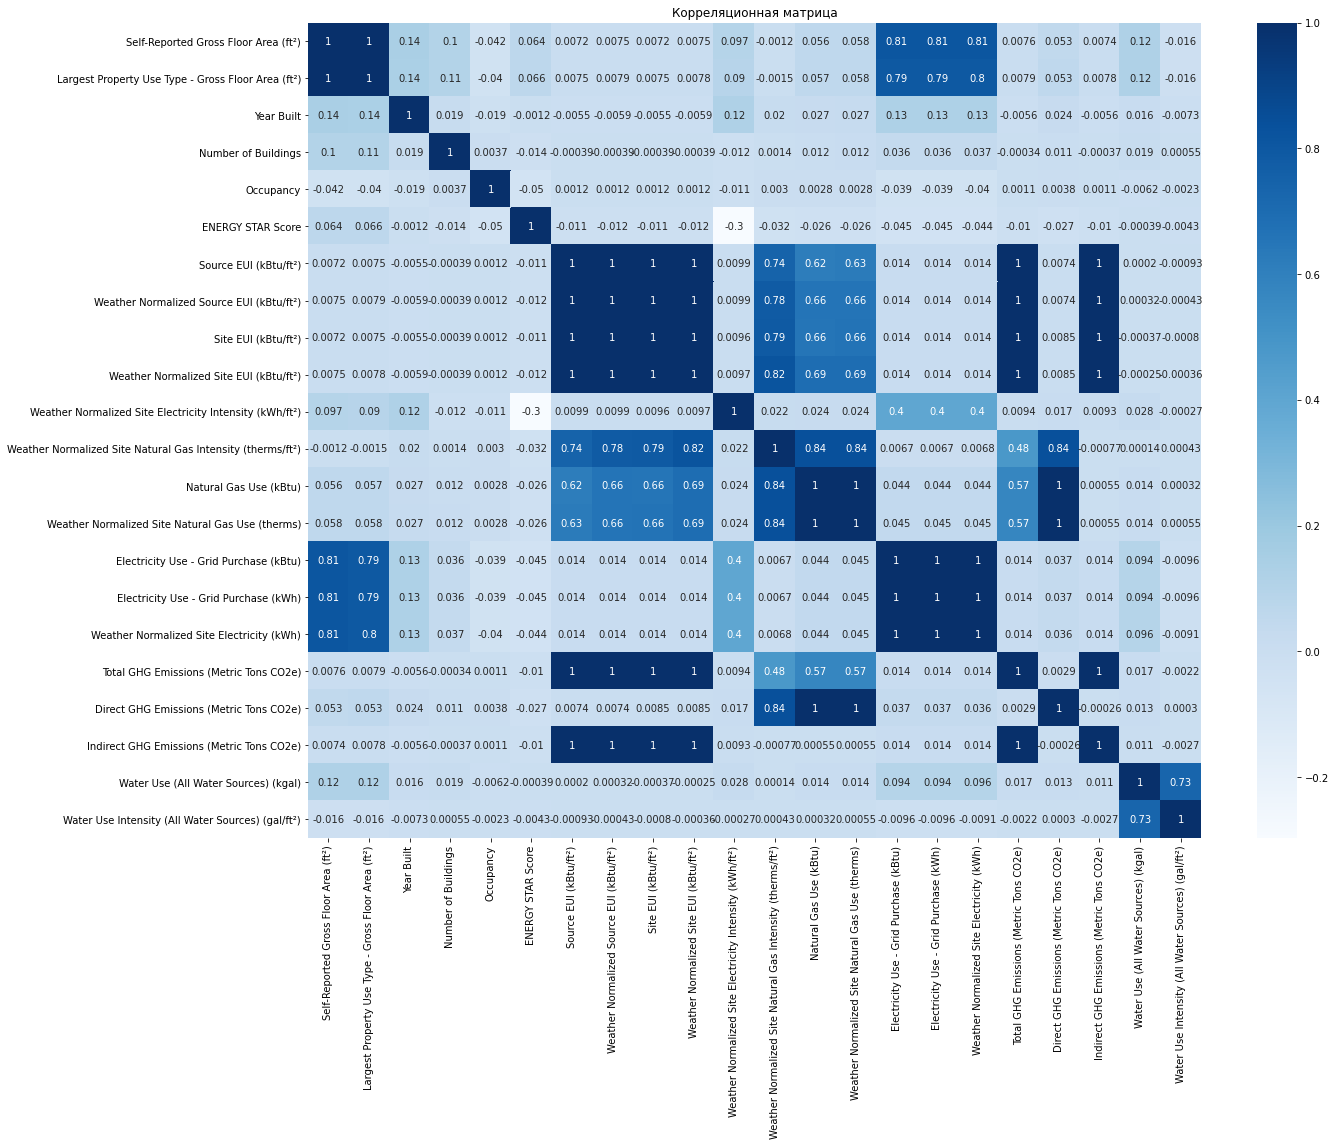

In [ ]:
correlation = df.corr()
plt.figure(figsize = (20,15))
sns.heatmap(correlation, cmap = 'Blues', annot = True)
plt.title('Корреляционная матрица')
plt.show()

По анализу корреляционной матрицы можно выделить один показатель Weather Normalized Site Electricity Intensity (kWh/ft²), влияющий на итоговое значение ENERGY STAR Score. Проверим влияние этого показателя с помощью другого графика

In [ ]:
data = df.groupby('ENERGY STAR Score')['Weather Normalized Site Electricity Intensity (kWh/ft²)'].mean().reset_index()
data.head()

,ENERGY STAR Score,Weather Normalized Site Electricity Intensity (kWh/ft²)
0,1.0,21.207476
1,2.0,11.487955
2,3.0,12.532117
3,4.0,9.765560
4,5.0,9.889963


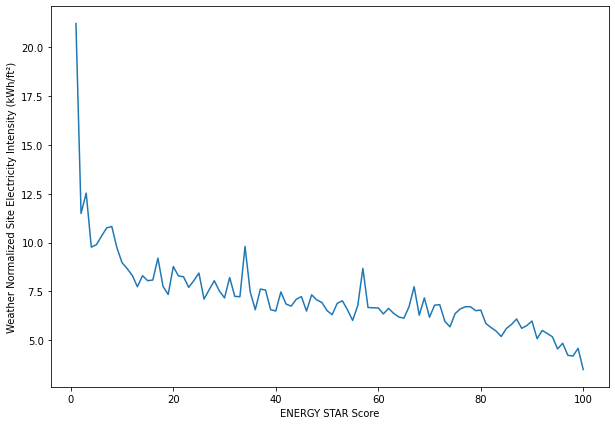

In [ ]:
plt.figure(figsize = (10,7))

plt.plot(data['ENERGY STAR Score'], data['Weather Normalized Site Electricity Intensity (kWh/ft²)'])

plt.xlabel('ENERGY STAR Score')
plt.ylabel('Weather Normalized Site Electricity Intensity (kWh/ft²)')

plt.show()

В целом, можно проследить тенденцию обратной зависимости Энергоэффективности здания (ENERGY STAR Score) от Электроэнергии на объекте, нормализованной по погодным условиям кВтч/фут² (Weather Normalized Site Electricity Intensity, kWh/ft²). Чем ниже Электроэнергия на объекте, нормализованная по погодным условиям, тем выше Энергоэффективность здания.

После построения предиктивной модели мы также проверим рейтинг важности признаков, влияющих на Энергоэффективность (ENERGY STAR Score) 

4. Разделить датасет на обучающие и тестовую  выборки.

In [ ]:
x = df.copy()
y = x.pop('ENERGY STAR Score')

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 5)

In [ ]:
# обработаем переменную район с помощью one hot encoding
x_train, x_ohe_train = x_train.drop(['Borough'], axis =1), x_train['Borough'].copy()
x_test, x_ohe_test = x_test.drop(['Borough'], axis =1),  x_test['Borough'].copy()

In [ ]:
x_ohe_train.head()

15743     brooklyn
4069     manhattan
23948     brooklyn
8975     manhattan
15436     brooklyn
Name: Borough, dtype: object

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
x_ohe_train = ohe.fit_transform(x_ohe_train.values.reshape(-1, 1))
x_ohe_train = pd.DataFrame(x_ohe_train, columns = ohe.get_feature_names())
x_ohe_test = ohe.transform(x_ohe_test.values.reshape(-1, 1))
x_ohe_test = pd.DataFrame(x_ohe_test, columns = ohe.get_feature_names())

In [ ]:
x_ohe_train.head()

,x0_bronx,x0_brooklyn,x0_manhattan,x0_patchogue,x0_queens,x0_staten island
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# обработаем переменные с типами здания и самого большого помещения  с помощью frequency encoding
x_train, x_fr_train = x_train.drop(['Primary Property Type - Self Selected','Largest Property Use Type'], axis =1), x_train[['Primary Property Type - Self Selected','Largest Property Use Type']].copy()
x_test, x_fr_test = x_test.drop(['Primary Property Type - Self Selected','Largest Property Use Type'], axis =1),  x_test[['Primary Property Type - Self Selected','Largest Property Use Type']].copy()

In [ ]:
x_fr_train.head()

,Primary Property Type - Self Selected,Largest Property Use Type
15743,Multifamily Housing,Multifamily Housing
4069,Office,Office
23948,Multifamily Housing,Multifamily Housing
8975,Multifamily Housing,Multifamily Housing
15436,Multifamily Housing,Multifamily Housing


In [ ]:
x_fr_train['Primary Property Type - Self Selected'].value_counts()

Multifamily Housing                           15177
Office                                         1939
K-12 School                                    1163
Hotel                                           374
Residence Hall/Dormitory                        372
Non-Refrigerated Warehouse                      312
College/University                              196
Senior Care Community                           137
Retail Store                                    126
Distribution Center                             102
Worship Facility                                 85
Hospital (General Medical & Surgical)            79
Supermarket/Grocery Store                        78
Medical Office                                   62
Mixed Use Property                               28
Refrigerated Warehouse                           28
Other                                            26
Courthouse                                       19
Financial Office                                 15
Other - Educ

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.6MB/s 


In [ ]:
from category_encoders.count import CountEncoder

ce = CountEncoder(handle_unknown = 1)
x_fr_train = ce.fit_transform(x_fr_train)
x_fr_test = ce.transform(x_fr_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x_fr_train.head()

,Primary Property Type - Self Selected,Largest Property Use Type
15743,15177,15188
4069,1939,1976
23948,15177,15188
8975,15177,15188
15436,15177,15188


In [ ]:
# обработаем название всех типов помещений по методике tfidf
x_train, x_tf_train = x_train.drop(['List of All Property Use Types at Property'], axis =1), x_train['List of All Property Use Types at Property'].copy()
x_test, x_tf_test = x_test.drop(['List of All Property Use Types at Property'], axis =1),  x_test['List of All Property Use Types at Property'].copy()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(max_features = 50)
x_tf_train = vec.fit_transform(x_tf_train)
x_tf_test = vec.transform(x_tf_test)

x_tf_train = pd.DataFrame(x_tf_train.toarray(), columns=vec.get_feature_names())
x_tf_test = pd.DataFrame(x_tf_test.toarray(), columns=vec.get_feature_names())

In [ ]:
x_tf_train.head()

,12,assembly,bank,branch,care,center,clinic,community,data,distribution,dormitory,entertainment,etc,facility,fast,financial,food,gas,general,grocery,hall,health,hospital,hotel,housing,medical,multifamily,non,office,other,outpatient,parking,pool,public,refrigerated,residence,restaurant,retail,school,senior,services,station,store,supermarket,surgical,swimming,urgent,warehouse,without,worship
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.503731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500869,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.311168,0.0,0.0,0.380544,0.0,0.0,0.0,0.503731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.848005,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.191667,0.0,0.191667,0.0,0.455428,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.707107,0.0,0.707107,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# обрабатывать переменную с адресом окзалось затратно по времени, поэтому мы ее удаляем
x_train = x_train.drop('Address 1 (self-reported)', axis = 1)
x_test = x_test.drop('Address 1 (self-reported)', axis = 1)

In [ ]:
# в переменной x_train остались только числовые фичи, прошкалируем их 
from sklearn.preprocessing import MinMaxScaler

mc = MinMaxScaler()
cols = x_train.columns
x_train = mc.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = cols)
x_test= mc.transform(x_test)
x_test = pd.DataFrame(x_test, columns = cols)

In [ ]:
# объединим старые числовые переменные и новые фичи (тоже теперь числовые)
x_train = pd.concat([x_train.reset_index(drop=True),
                     x_fr_train.reset_index(drop=True),
                     x_tf_train.reset_index(drop=True),
                     x_ohe_train.reset_index(drop=True)], 
                    axis = 1, ignore_index=False)
y_train = y_train.reset_index(drop=True)

x_test = pd.concat([x_test.reset_index(drop=True),
                     x_fr_test.reset_index(drop=True),
                     x_tf_test.reset_index(drop=True),
                     x_ohe_test.reset_index(drop=True)], 
                    axis = 1, ignore_index=False)
y_test = y_test.reset_index(drop=True)

In [ ]:
# еще раз посмотрим на пропущенные значения
(x_train.isna().sum()/len(x_train)).sort_values(ascending = False)

Water Use Intensity (All Water Sources) (gal/ft²)             0.437853
Water Use (All Water Sources) (kgal)                          0.437853
Weather Normalized Site Natural Gas Use (therms)              0.115258
Weather Normalized Site Natural Gas Intensity (therms/ft²)    0.115258
Weather Normalized Source EUI (kBtu/ft²)                      0.106320
                                                                ...   
outpatient                                                    0.000000
parking                                                       0.000000
pool                                                          0.000000
public                                                        0.000000
Self-Reported Gross Floor Area (ft²)                          0.000000
Length: 79, dtype: float64

In [ ]:
# заменим пропущенные значения в исходных числовых фичах по методу k-ближайших соседей
from sklearn.impute import KNNImputer

knn = KNNImputer()
cols = x_train.columns
x_train = knn.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns = cols)
x_test= knn.transform(x_test)
x_test = pd.DataFrame(x_test, columns = cols)

In [ ]:
(x_train.isna().sum()/len(x_train)).sort_values(ascending = False)

x0_staten island                         0.0
center                                   0.0
Primary Property Type - Self Selected    0.0
Largest Property Use Type                0.0
12                                       0.0
                                        ... 
outpatient                               0.0
parking                                  0.0
pool                                     0.0
public                                   0.0
Self-Reported Gross Floor Area (ft²)     0.0
Length: 79, dtype: float64

5. Обучить регрессионную модель и выявить показатели качества модели на обучающей и тестовой выборке.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 500, max_depth = 5, random_state = 42)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pred_train = rf.predict(x_train)
pred_test = rf.predict(x_test)

In [ ]:
print("Средняя абсолютная ошибка (MAE) модели на обучающей выборке {}".format(mean_absolute_error(y_train, pred_train)))
print("Средняя абсолютная ошибка (MAE) модели на тестовой выборке {}".format(mean_absolute_error(y_test, pred_test)))

print("Средняя квадратическая ошибка (MSE) модели на обучающей выборке {}".format(mean_squared_error(y_train, pred_train)))
print("Средняя квадратическая ошибка (MSE) модели на тестовой выборке {}".format(mean_squared_error(y_test, pred_test)))

print("Коэффициент детерминации (R^2) модели на обучающей выборке {}".format(r2_score(y_train, pred_train)))
print("Коэффициент детерминации (R^2) модели на тестовой выборке {}".format(r2_score(y_test, pred_test)))

Средняя абсолютная ошибка (MAE) модели на обучающей выборке 10.613263693222782
Средняя абсолютная ошибка (MAE) модели на тестовой выборке 10.75009917969335
Средняя квадратическая ошибка (MSE) модели на обучающей выборке 206.31763848268895
Средняя квадратическая ошибка (MSE) модели на тестовой выборке 210.70658033299208
Коэффициент детерминации (R^2) модели на обучающей выборке 0.8056944311935477
Коэффициент детерминации (R^2) модели на тестовой выборке 0.80079081144989


Коэффициенты детерминации (R^2) модели на обучающей и тестовой выборках практически идентичны, что говорит о достаточной степени обучения модели. При этом, последний показатель чуть выше 0.8, что также свидетельствует о довольно высокой точности модели. Тем не менее, мы постараемся достичь лучших показателей

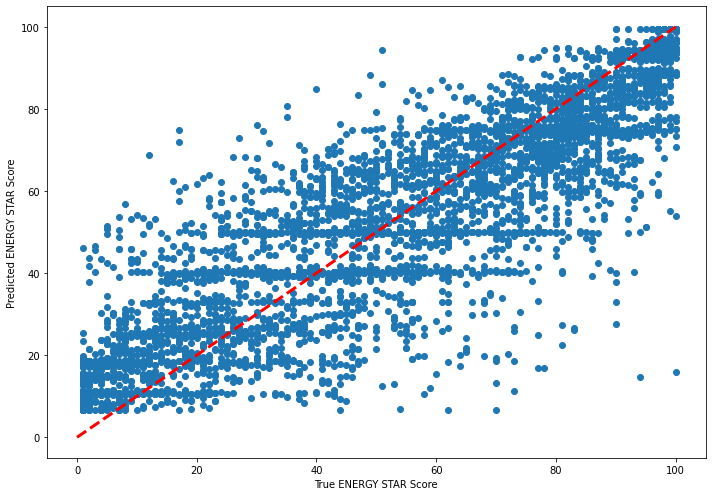

In [ ]:
# построим график точности модели

plt.figure(figsize=(10, 7))
plt.scatter(y_test, pred_test)
plt.plot([0, 100], [0, 100], '--k', color='red', linewidth=3)
plt.xlabel('True ENERGY STAR Score')
plt.ylabel('Predicted ENERGY STAR Score')
plt.tight_layout()

In [ ]:
# выведем рейтинг важности признаков с учетом их взаимодействий

feature_scores = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores.head(30)

Source EUI (kBtu/ft²)                                         0.763957
Site EUI (kBtu/ft²)                                           0.147404
Largest Property Use Type                                     0.031764
housing                                                       0.016145
multifamily                                                   0.015608
Primary Property Type - Self Selected                         0.006975
office                                                        0.003002
Largest Property Use Type - Gross Floor Area (ft²)            0.002678
Weather Normalized Site Electricity Intensity (kWh/ft²)       0.002566
non                                                           0.002323
warehouse                                                     0.001254
refrigerated                                                  0.001070
Indirect GHG Emissions (Metric Tons CO2e)                     0.001048
Self-Reported Gross Floor Area (ft²)                          0.000984
Weathe

После построения предиктивной модели мы видим, что больше всего на Энергоэффективность здания (ENERGY STAR Score) оказывает влияние Интенсивность использования энергии источника, кБТЕ/фут² (Source EUI, kBtu/ft²) - 76.69%. При этом, зависимость от расмотренного нами ранее показателя Электроэнергия на объекте, нормализованная по погодным условиям кВтч/фут² (Weather Normalized Site Electricity Intensity, kWh/ft²) несущественна и составляет всего 0.26%

6. Реализовать методы feature engineering с целью повышения метрик качества модели. 

In [ ]:
# сгенерим взаимодествия между столбцами
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True,include_bias = False)
x_train_2 = poly.fit_transform(x_train)
x_train_2 = pd.DataFrame(x_train_2, columns = poly.get_feature_names(x_train.columns))
x_test_2 = poly.fit_transform(x_test)
x_test_2 = pd.DataFrame(x_test_2, columns = poly.get_feature_names(x_test.columns))

In [ ]:
x_train_2.head()

,Self-Reported Gross Floor Area (ft²),Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Primary Property Type - Self Selected,Largest Property Use Type,12,assembly,bank,branch,care,center,clinic,community,data,distribution,dormitory,entertainment,etc,facility,fast,financial,food,...,urgent x0_manhattan,urgent x0_patchogue,urgent x0_queens,urgent x0_staten island,warehouse without,warehouse worship,warehouse x0_bronx,warehouse x0_brooklyn,warehouse x0_manhattan,warehouse x0_patchogue,warehouse x0_queens,warehouse x0_staten island,without worship,without x0_bronx,without x0_brooklyn,without x0_manhattan,without x0_patchogue,without x0_queens,without x0_staten island,worship x0_bronx,worship x0_brooklyn,worship x0_manhattan,worship x0_patchogue,worship x0_queens,worship x0_staten island,x0_bronx x0_brooklyn,x0_bronx x0_manhattan,x0_bronx x0_patchogue,x0_bronx x0_queens,x0_bronx x0_staten island,x0_brooklyn x0_manhattan,x0_brooklyn x0_patchogue,x0_brooklyn x0_queens,x0_brooklyn x0_staten island,x0_manhattan x0_patchogue,x0_manhattan x0_queens,x0_manhattan x0_staten island,x0_patchogue x0_queens,x0_patchogue x0_staten island,x0_queens x0_staten island
0,0.010688,0.010688,0.775656,0.006211,0.95,0.000468,0.000503,0.000385,0.000416,0.010885,0.000388,0.000536,0.000584,0.003155,0.003155,0.003295,0.000475,0.000536,0.018549,0.001850,0.001207,15177.0,15188.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.037718,0.026043,0.930788,0.006211,1.00,0.001305,0.001320,0.000602,0.000619,0.070225,0.000194,0.001415,0.001479,0.072581,0.072581,0.072764,0.003545,0.000000,0.021939,0.005522,0.001039,1939.0,1976.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.503731,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.018386,0.018386,0.727924,0.006211,1.00,0.000443,0.000469,0.000355,0.000380,0.011236,0.000340,0.000824,0.000892,0.005658,0.005658,0.005767,0.000753,0.000824,0.018621,0.003563,0.001365,15177.0,15188.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.018783,0.017665,0.906921,0.006211,1.00,0.000525,0.000543,0.000328,0.000352,0.021419,0.000000,0.000029,0.000030,0.011276,0.011276,0.011075,0.000961,0.000865,0.018796,0.002016,0.000756,15177.0,15188.0,0.0,0.0,0.0,0.0,0.0,0.848005,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.005651,0.005651,0.806683,0.006211,1.00,0.000634,0.000664,0.000465,0.000494,0.021770,0.000388,0.000292,0.000317,0.003474,0.003474,0.003506,0.000331,0.000323,0.018558,0.001033,0.001247,15177.0,15188.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
rf2 = RandomForestRegressor(n_estimators = 1000, max_depth = 30, max_features='log2', random_state=42)
rf2.fit(x_train_2, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
pred_train_2 = rf2.predict(x_train_2)
pred_test_2 = rf2.predict(x_test_2)

In [ ]:
print("Средняя абсолютная ошибка (MAE) модели на обучающей выборке rf2 {}".format(mean_absolute_error(y_train, pred_train_2)))
print("Средняя абсолютная ошибка (MAE) модели на тестовой выборке rf2 {}".format(mean_absolute_error(y_test, pred_test_2)))

print("Средняя квадратическая ошибка (MSE) модели на обучающей выборке rf2 {}".format(mean_squared_error(y_train, pred_train_2)))
print("Средняя квадратическая ошибка (MSE) модели на тестовой выборке rf2 {}".format(mean_squared_error(y_test, pred_test_2)))

print("Коэффициент детерминации (R^2) модели на обучающей выборке rf2 {}".format(r2_score(y_train, pred_train_2)))
print("Коэффициент детерминации (R^2) модели на тестовой выборке rf2 {}".format(r2_score(y_test, pred_test_2)))

Средняя абсолютная ошибка (MAE) модели на обучающей выборке rf2 4.965680371001571
Средняя абсолютная ошибка (MAE) модели на тестовой выборке rf2 8.582561127571406
Средняя квадратическая ошибка (MSE) модели на обучающей выборке rf2 44.2968770464556
Средняя квадратическая ошибка (MSE) модели на тестовой выборке rf2 137.0042407152984
Коэффициент детерминации (R^2) модели на обучающей выборке rf2 0.9582821422629688
Коэффициент детерминации (R^2) модели на тестовой выборке rf2 0.8704715174168429


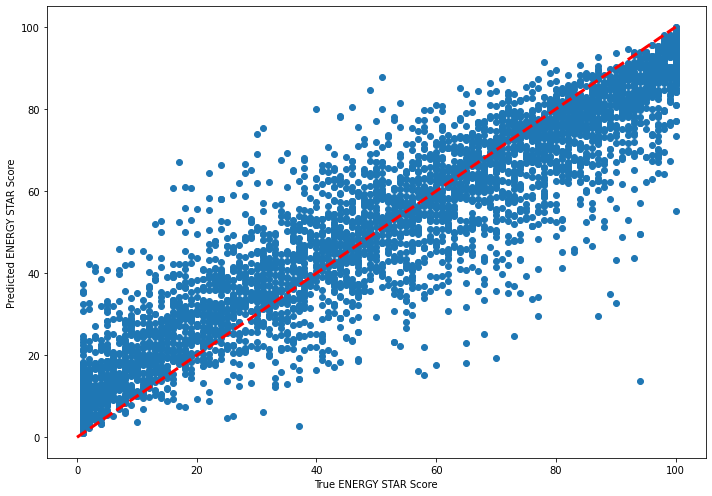

In [ ]:
# построим график точности модели

plt.figure(figsize=(10, 7))
plt.scatter(y_test, pred_test_2)
plt.plot([0, 100], [0, 100], '--k', color='red', linewidth=3)
plt.xlabel('True ENERGY STAR Score')
plt.ylabel('Predicted ENERGY STAR Score')
plt.tight_layout()

Мы улучшили предиктивную модель с помощью метода PolynomialFeatures, повысив коэффициент детерминации (R^2) модели на тестовой выборке rf2 до 0.87. При этом Средняя абсолютная ошибка (MAE) модели на тестовой выборке снизилась с 10.75 до 8.58. Тем не менее, наша новая модель переобучилась, так как коэффициент детерминации (R^2) модели на обучающей выборке rf2 значительно выше этого показателя на тестовой выборке.

In [ ]:
# выведем рейтинг важности признаков с учетом их взаимодействий

feature_scores = pd.Series(rf2.feature_importances_, index=x_train_2.columns).sort_values(ascending=False)
feature_scores.head(50)

Source EUI (kBtu/ft²)                                                                                                 0.017382
Occupancy Source EUI (kBtu/ft²)                                                                                       0.016633
Site EUI (kBtu/ft²)                                                                                                   0.016099
Occupancy Site EUI (kBtu/ft²)                                                                                         0.016045
Year Built Source EUI (kBtu/ft²)                                                                                      0.015434
Occupancy Weather Normalized Source EUI (kBtu/ft²)                                                                    0.014494
Source EUI (kBtu/ft²) Primary Property Type - Self Selected                                                           0.014418
Year Built Site EUI (kBtu/ft²)                                                                                 